## In this notebook I am going to implement a face identification Neural network described in Face Net paper

### Lets Start by importing all the required libraries

The inception_resnet_v1 file contains the code to create the required Inception Model

In [1]:
import numpy as np
import pandas as pd
from inception_resnet_v1 import *
from keras.preprocessing.image import load_img, save_img, img_to_array,array_to_img
import mtcnn
from PIL import Image
from mtcnn.mtcnn import MTCNN
from keras.applications.imagenet_utils import preprocess_input

## We will create our model using the InceptionResNetV1() method in inception_resnet_v1 file

The input shape is (90,90,3)
facenet_weights.h5 file contains the weights of the pre-trained model

In [2]:
model = InceptionResNetV1(input_shape=(90,90,3))
model.load_weights('facenet_weights.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 90, 90, 3)    0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 44, 44, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 44, 44, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 44, 44, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

### Let us create two utility functions required

In [3]:
def l2_normalize(x):
    """
    This Function applies L2 normalization of the given input
    
    Agrument:
    Input: The Differenct between The actual and predicted encoding.
    """
    return x / np.sqrt(np.sum(np.multiply(x, x)))

def findEuclideanDistance(source_representation, test_representation):
    """
    This function calculates the euclidean distance between the two given vectors
    
    Argument:
    source_representation: The encoded vector of the actual stored image
    test_representaion: The encoded vector of the tnew image
    """
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

## Aligning The Image

We need images to only have the face and nothing else. So we need to align the image. This is done using the MTCNN library

In [4]:
def preprocess_image_align(image_path):
    """
    This function aligns the given image and returns the aligned image
    
    Argument:
    image_path: The path of the image
    """
    image = load_img(image_path,target_size=(1024,1024))
    image = img_to_array(image)
    detector = MTCNN()
    box = detector.detect_faces(image)
    x1,y1,width,heigth = box[0]['box']
    x1= abs(x1)
    y1=abs(y1)
    x2 = x1 + width
    y2 = y1 + heigth
    img = image[y1:y2,x1:x2]
    
    image = array_to_img(img)
    image = image.resize((90,90))
    return image

## Preprocessing the aligned image

In [5]:
def preprocess_image(image_path):
    """
    Used To preprocess the Image
    
    Argumwnts:
    image_path : Location of the image
    """
    image = preprocess_image_align(image_path)
    
    
    
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    image = preprocess_input(image)
    return image

## We will store the encodings of the actual image in a .npy file
The functions required to add,retrive the encodings

In [6]:
def add_data(name,image_path):
    """
    Function To Add the Name and gennetate the encodings of authenticated persons. It stores the name 
    and the encodinng in a dictionary annd stores it.
    
    Arguments:
    name: The Name of The Preson In The Image
    image_path: The Location Of The Image
    """
    dictionary = np.load('dataset.npy').item()
    dictionary[name]= l2_normalize(model.predict(preprocess_image(image_path))[0,:])
    
    np.save('dataset.npy',dictionary)

def print_dataset():
    """
    This Function Prinnts the Dictionary containing the Names Annd Encodings of Authennticated Persons
    """
    dictionary = np.load('dataset.npy').item()
    
    for name,encoding in dictionary.items():
        print("Name :"+ str(name) + "Encoding:" + str(encoding))

def return_dictionary():
    """
    It returns the dictionary
    """
    return np.load('dataset.npy').item()

def clear_dictionary():
    """
    It clears the dictionary
    """
    dictionary = np.load('dataset.npy').item()
    dictionary.clear()
    np.save('dataset.npy',dictionary)

def delete_element(name):
    """
    It deletes an element from the dictionary
    """
    dictionary = np.load('dataset.npy').item()
    del dictionary[name]
    np.save('dataset.npy',dictionary)

# The method to detect the face

model.predict(image) will generate the required 128 bit encoding to the image

In [30]:
def detect_face(image_path):
    """
    This Funnction Detects The face and prints wether it is verified or not
    """
    encoding_2 = l2_normalize(model.predict(preprocess_image(image_path))[0,:])
    
    min_distance =100
    name_of_the_person=''
    for name,encoding in return_dictionary().items():
        distance = findEuclideanDistance(encoding,encoding_2)
        
        if distance<min_distance:
            min_distance = distance
            name_of_the_person = name
    if min_distance < 0.5:
        
        return name_of_the_person[:-1]
    else:
        
        return "Not verified"

Let Us add an image of a celebrity and find out if our model can predict the Image

In [35]:
add_data('Taylor2','images/Taylor3.jpg')

In [41]:
detect_face('new_images/Taylor.jpg')

'Taylor'

## Actual Image

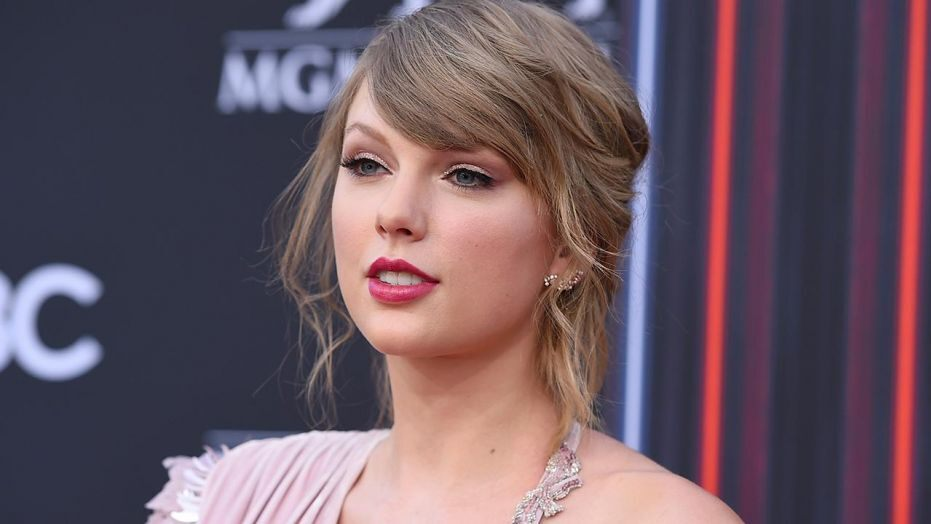

In [44]:
from IPython.display import Image
Image('images/Taylor3.jpg')

## The New Image

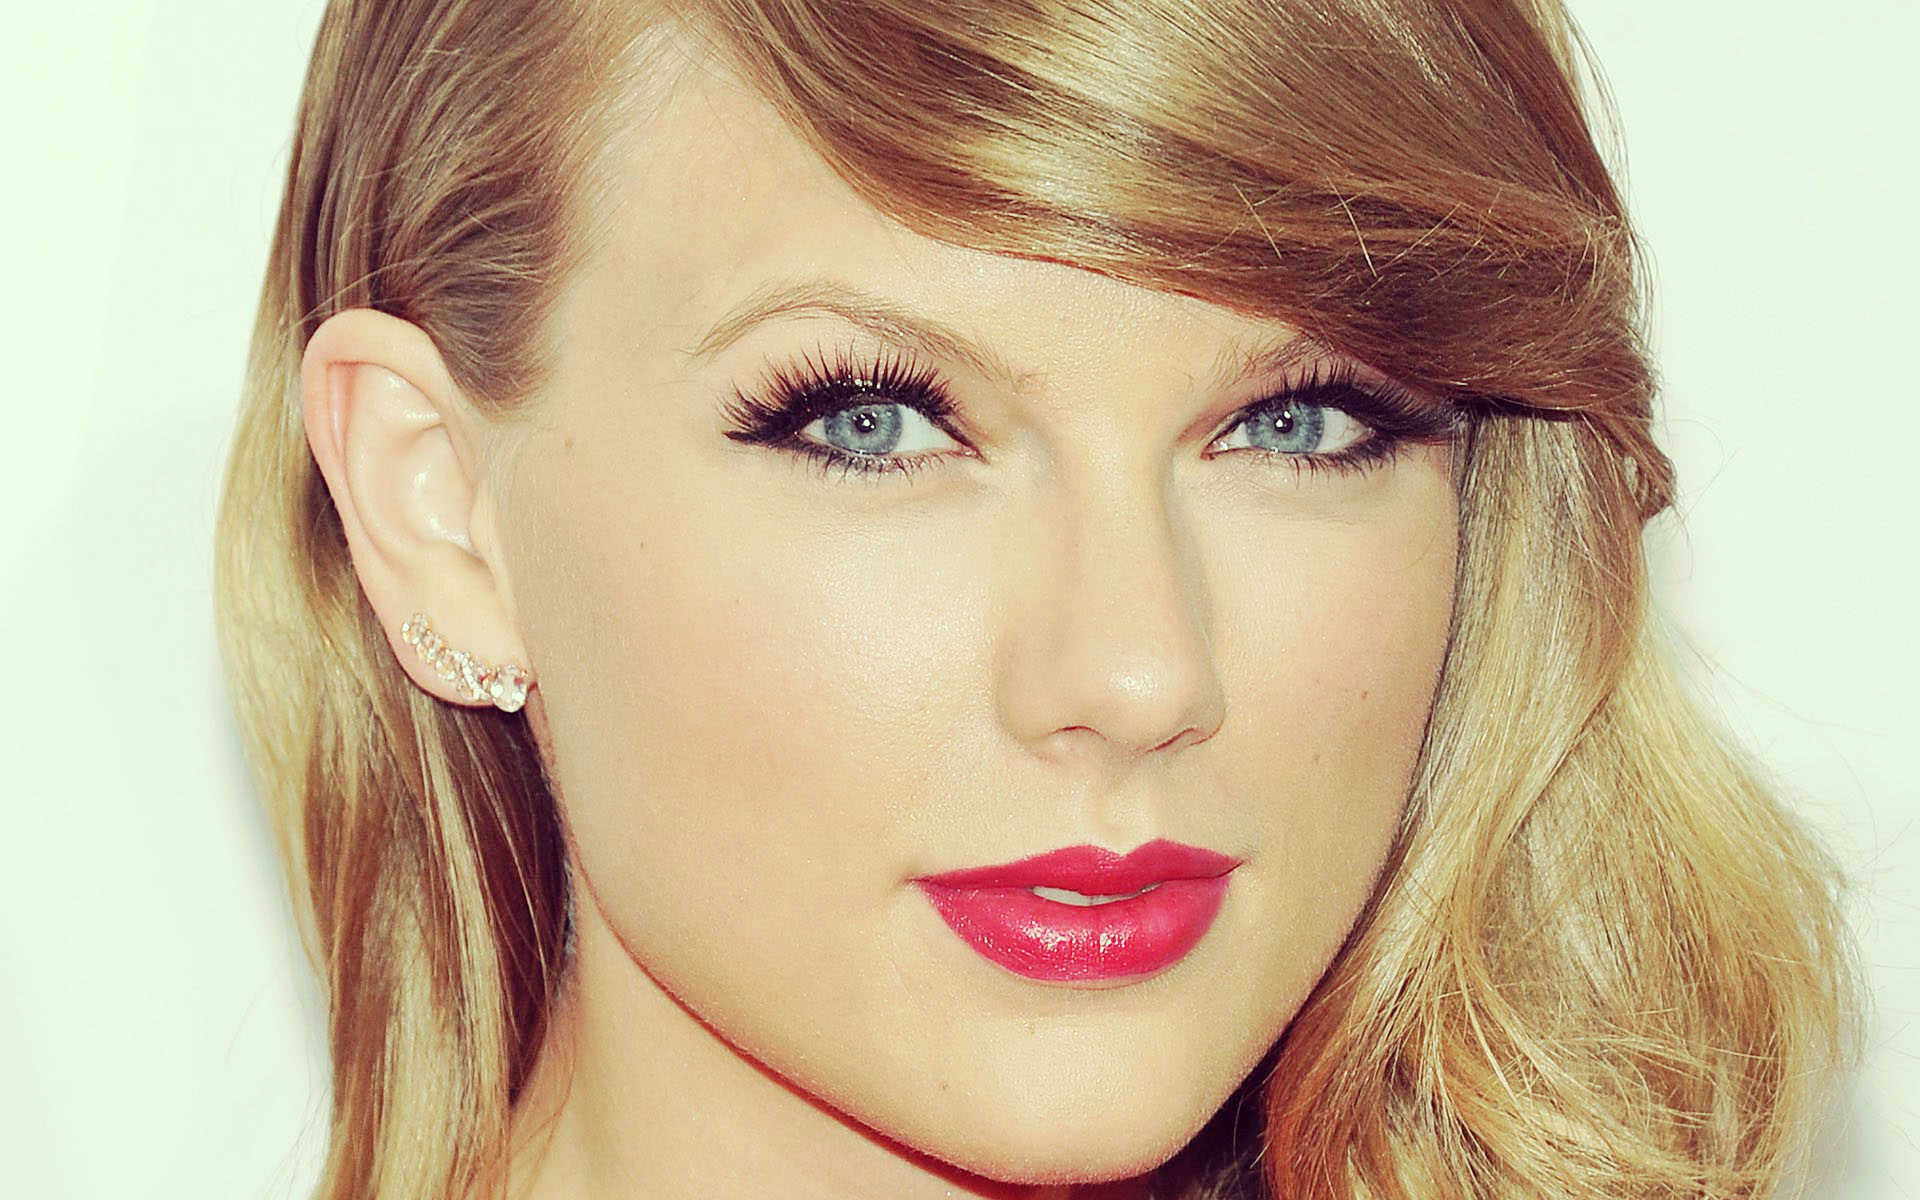

In [43]:
from IPython.display import Image
Image('new_images/Taylor.jpg')

## We can conclude that our model is able to detect face of various Persons in a given Image

We can imporve the model by storing maybe 10 images of each person taken in different angles to make our model more robust